In [803]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [804]:
import warnings
warnings.filterwarnings('ignore')

In [805]:
matplotlib.rcParams.update({'font.size': 10})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
pd.set_option('max_colwidth', 200)

In [806]:
TRAIN_DATASET_PATH = '/Users/sonzza/Python_2_lessons/Finishhim/train.csv'
TEST_DATASET_PATH = '/Users/sonzza/Python_2_lessons/Finishhim/test.csv'

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [807]:
def evaluate_preds(train_true_values, train_pred_values, val_true_values, val_pred_values):
    """
    Функция для оценки работы модели
    Parameters:
    train_true_values - целевая переменная из тренировочной части датасета
    train_pred_values - предсказания модели по тренировочной части
    val_true_values - целевая переменная из валидационной части датасета
    val_pred_values - предсказания модели по валидационной части
    Returns:
    R2 на тренировочной и валидационной части, 
    графики зависимости истинных значений от предсказаний
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Valid R2:\t" + str(round(r2(val_true_values, val_pred_values), 3)))
    
    plt.figure(figsize=(12,8))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=val_pred_values, y=val_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    plt.show()

In [808]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
display(train_df.sample(7))
print(train_df.shape)

Id  DistrictId   Rooms   Square  LifeSquare  KitchenSquare  Floor  \
1969  13476          30 2.00000 66.28311         nan        1.00000     10   
9263   3412           6 1.00000 42.76374         nan        0.00000      2   
6014   5866         138 3.00000 57.38619    44.97891        5.00000      9   
9779   6793          27 1.00000 43.10881         nan        1.00000     11   
8445   3446          11 3.00000 90.12038    60.10686        9.00000      3   
1609  14969           9 3.00000 86.80240     5.41993        1.00000      5   
1323   8531           1 1.00000 42.83920         nan        1.00000     13   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1969    17.00000       1977    0.00008         B         B        22   
9263    17.00000       1977    0.24320         B         B         5   
6014     9.00000       1968    0.19578         B         B        23   
9779    17.00000       1977    0.21140         B         B         9   
8445    12.00000       1958    0.00017         B         B        36   
1609     1.00000       1977    0.16153         B         B        25   
1323    17.00000       1977    0.00712         B         B         1   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
1969      6398       141    1046.00000            3       23       B   
9263      1564         0     540.00000            0        0       B   
6014      5212         6           nan            3        2       B   
9779      1892         0           nan            0        1       B   
8445      5992         0           nan            1        1       B   
1609      5648         1      30.00000            2        4       B   
1323       264         0           nan            0        1       B   

            Price  
1969 205978.53974  
9263 125447.13884  
6014 333178.71874  
9779  99530.02189  
8445 323254.40598  
1609 238084.20830  
1323 147308.00040

(10000, 20)


In [809]:
train_df.describe()

Id  DistrictId       Rooms      Square  LifeSquare  \
count 10000.00000 10000.00000 10000.00000 10000.00000  7887.00000   
mean   8383.40770    50.40080     1.89050    56.31578    37.19964   
std    4859.01902    43.58759     0.83951    21.05873    86.24121   
min       0.00000     0.00000     0.00000     1.13686     0.37062   
25%    4169.50000    20.00000     1.00000    41.77488    22.76983   
50%    8394.50000    36.00000     2.00000    52.51331    32.78126   
75%   12592.50000    75.00000     2.00000    65.90063    45.12880   
max   16798.00000   209.00000    19.00000   641.06519  7480.59213   

       KitchenSquare       Floor  HouseFloor      HouseYear   Ecology_1  \
count    10000.00000 10000.00000 10000.00000    10000.00000 10000.00000   
mean         6.27330     8.52670    12.60940     3990.16630     0.11886   
std         28.56092     5.24115     6.77597   200500.26143     0.11903   
min          0.00000     1.00000     0.00000     1910.00000     0.00000   
25%          1.00000     4.00000     9.00000     1974.00000     0.01765   
50%          6.00000     7.00000    13.00000     1977.00000     0.07542   
75%          9.00000    12.00000    17.00000     2001.00000     0.19578   
max       2014.00000    42.00000   117.00000 20052011.00000     0.52187   

         Social_1    Social_2    Social_3  Healthcare_1  Helthcare_2  \
count 10000.00000 10000.00000 10000.00000    5202.00000  10000.00000   
mean     24.68700  5352.15740     8.03920    1142.90446      1.31950   
std      17.53261  4006.79980    23.83187    1021.51726      1.49360   
min       0.00000   168.00000     0.00000       0.00000      0.00000   
25%       6.00000  1564.00000     0.00000     350.00000      0.00000   
50%      25.00000  5285.00000     2.00000     900.00000      1.00000   
75%      36.00000  7227.00000     5.00000    1548.00000      2.00000   
max      74.00000 19083.00000   141.00000    4849.00000      6.00000   

          Shops_1        Price  
count 10000.00000  10000.00000  
mean      4.23130 214138.85740  
std       4.80634  92872.29387  
min       0.00000  59174.77803  
25%       1.00000 153872.63394  
50%       3.00000 192269.64488  
75%       6.00000 249135.46217  
max      23.00000 633233.46657

In [810]:
test_df = pd.read_csv(TEST_DATASET_PATH)
display(test_df.sample(7))
print(test_df.shape)

Id  DistrictId   Rooms   Square  LifeSquare  KitchenSquare  Floor  \
911   12618          61 2.00000 55.62957    34.33075        8.00000     12   
4818   8963          27 3.00000 79.11439     3.32922        1.00000      3   
3595  15599           6 2.00000 61.44317    64.47804        1.00000      5   
3425  11540           6 3.00000 82.71095    46.98117        9.00000     13   
3306   4623         128 3.00000 77.42608    41.46442        8.00000     11   
2419  10610         185 1.00000 38.21588    20.53536        7.00000      8   
3776  13456           6 1.00000 38.90625    22.77819        6.00000      9   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
911     12.00000       1985    0.30032         B         B        52   
4818    22.00000       1977    0.21140         B         B         9   
3595    17.00000       2016    0.24320         B         B         5   
3425    17.00000       2010    0.24320         B         B         5   
3306    14.00000       1991    0.00000         B         B        27   
2419    17.00000       2003    0.02561         B         B        33   
3776    17.00000       2015    0.24320         B         B         5   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
911      10311         6           nan            1        9       B  
4818      1892         0           nan            0        1       B  
3595      1564         0     540.00000            0        0       B  
3425      1564         0     540.00000            0        0       B  
3306      4798         0      30.00000            2        8       B  
2419      5261         0     240.00000            3        1       B  
3776      1564         0     540.00000            0        0       B

(5000, 19)


In [731]:
test_df.describe()

Id  DistrictId      Rooms     Square  LifeSquare  \
count  5000.00000  5000.00000 5000.00000 5000.00000  3959.00000   
mean   8412.59540    51.27920    1.91000   56.44950    36.15881   
std    4832.67404    44.17947    0.83859   19.09279    17.82529   
min       1.00000     0.00000    0.00000    1.37854     0.33349   
25%    4221.75000    21.00000    1.00000   41.90623    23.09203   
50%    8320.50000    37.00000    2.00000   52.92134    32.92509   
75%   12598.25000    77.00000    2.00000   66.28513    45.17409   
max   16795.00000   212.00000   17.00000  223.45369   303.07109   

       KitchenSquare      Floor  HouseFloor  HouseYear  Ecology_1   Social_1  \
count     5000.00000 5000.00000  5000.00000 5000.00000 5000.00000 5000.00000   
mean         5.97680    8.63200    12.60100 1984.39260    0.11987   24.93380   
std          9.95002    5.48323     6.78921   18.57315    0.12007   17.53220   
min          0.00000    1.00000     0.00000 1908.00000    0.00000    0.00000   
25%          1.00000    4.00000     9.00000 1973.00000    0.01951    6.00000   
50%          6.00000    7.00000    12.00000 1977.00000    0.07216   25.00000   
75%          9.00000   12.00000    17.00000 2000.00000    0.19578   36.00000   
max        620.00000   78.00000    99.00000 2020.00000    0.52187   74.00000   

         Social_2   Social_3  Healthcare_1  Helthcare_2    Shops_1  
count  5000.00000 5000.00000    2623.00000   5000.00000 5000.00000  
mean   5406.90000    8.26260    1146.65726      1.31940    4.24280  
std    4026.61477   23.86376    1044.74423      1.47994    4.77736  
min     168.00000    0.00000       0.00000      0.00000    0.00000  
25%    1564.00000    0.00000     325.00000      0.00000    1.00000  
50%    5285.00000    2.00000     900.00000      1.00000    3.00000  
75%    7287.00000    5.00000    1548.00000      2.00000    6.00000  
max   19083.00000  141.00000    4849.00000      6.00000   23.00000

In [732]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [733]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


In [734]:
test_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [735]:
test_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [736]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = 0

In [737]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = 0

In [738]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = 0

In [739]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = 0

In [740]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       5000 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     5000 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


In [741]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     10000 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [742]:
train_df.describe(include=['O']).T

count unique top  freq
Ecology_2  10000      2   B  9903
Ecology_3  10000      2   B  9725
Shops_2    10000      2   B  9175

In [743]:
test_df.describe(include=['O']).T

count unique top  freq
Ecology_2  5000      2   B  4952
Ecology_3  5000      2   B  4851
Shops_2    5000      2   B  4588

In [744]:
train_df['Ecology_2'] = train_df['Ecology_2'].replace({'A':0, 'B':1}).astype(int)
train_df['Ecology_3'] = train_df['Ecology_3'].replace({'A':0, 'B':1}).astype(int)
train_df['Shops_2'] = train_df['Shops_2'].replace({'A':0, 'B':1}).astype(int)

In [745]:
test_df['Ecology_2'] = test_df['Ecology_2'].replace({'A':0, 'B':1}).astype(int)
test_df['Ecology_3'] = test_df['Ecology_3'].replace({'A':0, 'B':1}).astype(int)
test_df['Shops_2'] = test_df['Shops_2'].replace({'A':0, 'B':1}).astype(int)

In [746]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null int64
Ecology_3        10000 non-null int64
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     10000 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null int64
Price            10000 non-null float64
dtypes: float64(8), int64(12)
memory usage: 1.5 MB


In [747]:
train_df['Rooms'].value_counts()

2.00000     3880
1.00000     3705
3.00000     2235
4.00000      150
5.00000       18
0.00000        8
10.00000       2
19.00000       1
6.00000        1
Name: Rooms, dtype: int64

In [748]:
test_df['Rooms'].value_counts()

2.00000     2030
1.00000     1769
3.00000     1099
4.00000       90
5.00000        7
0.00000        2
6.00000        2
17.00000       1
Name: Rooms, dtype: int64

In [749]:
train_df['Rooms'] = train_df['Rooms'].replace({10:1, 19:2})

In [750]:
test_df['Rooms'] = test_df['Rooms'].replace({17:2})

In [751]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [752]:
train_df['HouseYear'] = train_df['HouseYear'].replace({20052011:2011, 4968:1968})

In [753]:
feat_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']

In [754]:
train_df['HouseYear'].sort_values().unique()

array([1910, 1912, 1914, 1916, 1917, 1918, 1919, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942,
       1947, 1948, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [755]:
train_df.loc[train_df['Square'] > 80, 'Square'] = train_df['Square'].mean()
train_df.loc[train_df['LifeSquare'] >= 60, 'LifeSquare'] = train_df['LifeSquare'].mean()
train_df.loc[train_df['KitchenSquare'] >= 40, 'KitchenSquare'] = train_df['KitchenSquare'].mean()

In [756]:
test_df.loc[test_df['Square'] > 80, 'Square'] = test_df['Square'].mean()
test_df.loc[test_df['LifeSquare'] >= 60, 'LifeSquare'] = test_df['LifeSquare'].mean()
test_df.loc[test_df['KitchenSquare'] >= 40, 'KitchenSquare'] = test_df['KitchenSquare'].mean()

In [757]:
X = train_df[feat_names]
y = train_df['Price']

In [758]:
test_df.describe()

Id  DistrictId      Rooms     Square  LifeSquare  \
count  5000.00000  5000.00000 5000.00000 5000.00000  5000.00000   
mean   8412.59540    51.27920    1.90700   52.19898    25.33515   
std    4832.67404    44.17947    0.81098   12.52805    16.49327   
min       1.00000     0.00000    0.00000    1.37854     0.00000   
25%    4221.75000    21.00000    1.00000   41.90623    17.87373   
50%    8320.50000    37.00000    2.00000   52.92134    28.63055   
75%   12598.25000    77.00000    2.00000   60.57467    35.97566   
max   16795.00000   212.00000    6.00000   79.99333    59.98278   

       KitchenSquare      Floor  HouseFloor  HouseYear  Ecology_1  Ecology_2  \
count     5000.00000 5000.00000  5000.00000 5000.00000 5000.00000 5000.00000   
mean         5.71654    8.63200    12.60100 1984.39260    0.11987    0.99040   
std          3.87676    5.48323     6.78921   18.57315    0.12007    0.09752   
min          0.00000    1.00000     0.00000 1908.00000    0.00000    0.00000   
25%          1.00000    4.00000     9.00000 1973.00000    0.01951    1.00000   
50%          6.00000    7.00000    12.00000 1977.00000    0.07216    1.00000   
75%          9.00000   12.00000    17.00000 2000.00000    0.19578    1.00000   
max         34.00000   78.00000    99.00000 2020.00000    0.52187    1.00000   

       Ecology_3   Social_1    Social_2   Social_3  Healthcare_1  Helthcare_2  \
count 5000.00000 5000.00000  5000.00000 5000.00000    5000.00000   5000.00000   
mean     0.97020   24.93380  5406.90000    8.26260     601.53640      1.31940   
std      0.17005   17.53220  4026.61477   23.86376     948.92980      1.47994   
min      0.00000    0.00000   168.00000    0.00000       0.00000      0.00000   
25%      1.00000    6.00000  1564.00000    0.00000       0.00000      0.00000   
50%      1.00000   25.00000  5285.00000    2.00000      30.00000      1.00000   
75%      1.00000   36.00000  7287.00000    5.00000     990.00000      2.00000   
max      1.00000   74.00000 19083.00000  141.00000    4849.00000      6.00000   

         Shops_1    Shops_2  
count 5000.00000 5000.00000  
mean     4.24280    0.91760  
std      4.77736    0.27500  
min      0.00000    0.00000  
25%      1.00000    1.00000  
50%      3.00000    1.00000  
75%      6.00000    1.00000  
max     23.00000    1.00000

In [759]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.27, shuffle=True, random_state=42)

In [760]:
rfr_model = RandomForestRegressor(random_state=42)
rfr_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

Train R2:	0.946
Valid R2:	0.697


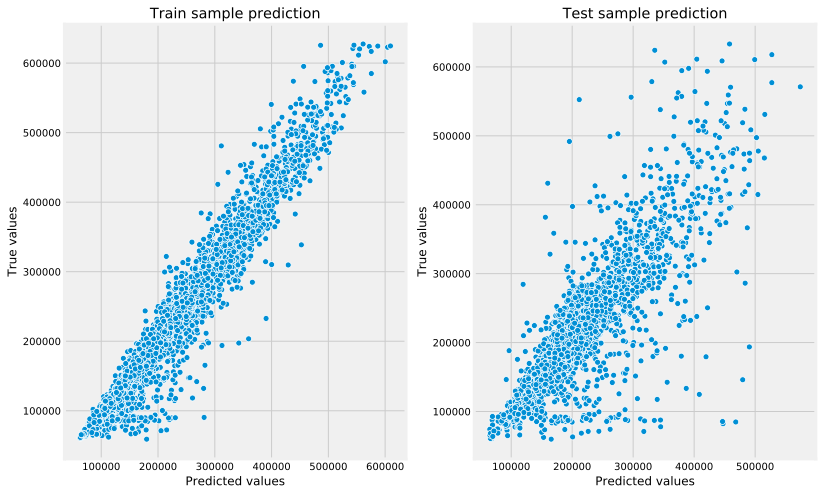

In [761]:
y_train_preds = rfr_model.predict(X_train)
y_val_preds = rfr_model.predict(X_val)

evaluate_preds(y_train, y_train_preds, y_val, y_val_preds)

In [762]:
cv_score = cross_val_score(rfr_model, X, y, scoring='r2', cv=KFold(n_splits=7, shuffle=True, random_state=42))
cv_score

array([0.70808282, 0.67244545, 0.71328576, 0.73646954, 0.65399927,
       0.71388621, 0.73905064])

In [763]:
test_df.head()

Id  DistrictId   Rooms   Square  LifeSquare  KitchenSquare  Floor  \
0    725          58 2.00000 49.88264    33.43278        6.00000      6   
1  15856          74 2.00000 69.26318     0.00000        1.00000      6   
2   5480         190 1.00000 13.59782    15.94825       12.00000      2   
3  15664          47 2.00000 73.04661    51.94084        9.00000     22   
4  14275          27 1.00000 47.52711    43.38757        1.00000     17   

   HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  \
0    14.00000       1972    0.31020          1          1        11      2748   
1     1.00000       1977    0.07578          1          1         6      1437   
2     5.00000       1909    0.00000          1          1        30      7538   
3    22.00000       2007    0.10187          1          1        23      4583   
4    17.00000       2017    0.07216          1          1         2       629   

   Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2  
0         1       0.00000            0        0        1  
1         3       0.00000            0        2        1  
2        87    4702.00000            5        5        1  
3         3       0.00000            3        3        1  
4         1       0.00000            0        0        0

In [764]:
X2 = test_df[feat_names]

In [765]:
y2_pred = rfr_model.predict(X2)

In [766]:
result = pd.DataFrame(data = {'Id': test_df.Id, 'Price': y2_pred})

In [767]:
result.head()

Id        Price
0    725 183580.91055
1  15856 199162.07049
2   5480 189416.54091
3  15664 324893.76490
4  14275 128958.60993

In [768]:
result.to_csv('result_depth.csv', index=False, quoting=3, sep=',')

In [769]:
scaler = StandardScaler()

In [770]:
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feat_names)

X_val_scaled = scaler.fit_transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feat_names)

In [771]:
X_train_scaled.head(5)

Rooms   Square  LifeSquare  KitchenSquare    Floor  HouseFloor  \
0 -1.09142 -1.00303    -1.52689       -1.17321  1.05274     0.63973   
1  0.14173  0.31640     0.34019        1.30415 -0.47978     0.49357   
2 -1.09142 -0.59481    -0.10570        0.56094  0.66961    -0.09108   
3 -1.09142 -0.62853     1.35020       -1.42094  1.62744     0.78590   
4  1.37487  1.17695     1.19855        0.80868 -1.43761     0.20124   

   HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  Social_3  \
0   -0.43100   -0.93276    0.09697    0.17083  -1.34900  -1.27053  -0.33737   
1   -0.10355   -0.99293    0.09697    0.17083   0.47096   0.51618  -0.29557   
2   -0.37642   -0.13231    0.09697    0.17083  -0.09778  -0.19291  -0.21197   
3    1.80657   -0.24072    0.09697    0.17083   0.47096   0.65366  -0.12837   
4   -0.43100    1.62155    0.09697    0.17083   0.58471   0.58854  -0.17017   

   Healthcare_1  Helthcare_2  Shops_1  Shops_2  
0      -0.63462     -0.88002 -0.67599  0.30142  
1      -0.63462      0.46620  0.15379  0.30142  
2      -0.63462      1.13930 -0.26110  0.30142  
3      -0.63462     -0.88002  1.39846  0.30142  
4       0.43538     -0.88002  0.36124  0.30142

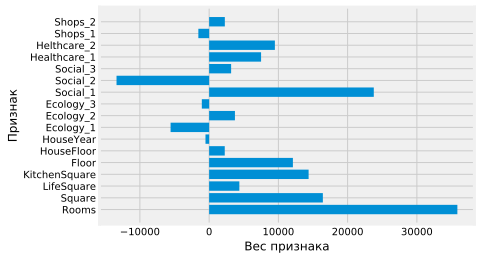

In [772]:
lr.fit(X_train_scaled, y_train)

plt.barh(feat_names, lr.coef_.flatten())

plt.xlabel("Вес признака")
plt.ylabel("Признак")

plt.show()

In [773]:
rfr_model.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

Train R2:	0.947
Valid R2:	0.665


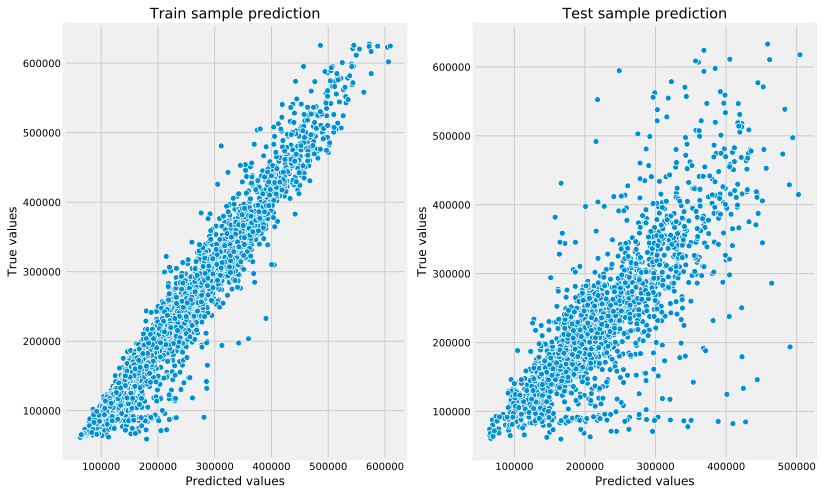

In [774]:
y1_train_preds = rfr_model.predict(X_train_scaled)
y1_val_preds = rfr_model.predict(X_val_scaled)

evaluate_preds(y_train, y1_train_preds, y_val, y1_val_preds)

In [229]:
feat_names_2 = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']

X = train_df[feat_names_2]
y = train_df['Price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.27, shuffle=True, random_state=42)

In [775]:
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feat_names)

X_val_scaled = scaler.fit_transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feat_names)

In [776]:
rfr_model = RandomForestRegressor(random_state=42)
rfr_model.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

Train R2:	0.947
Valid R2:	0.665


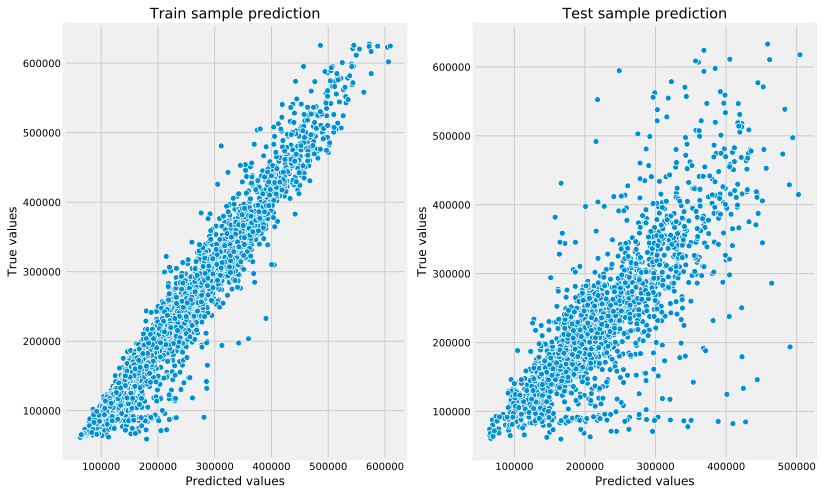

In [777]:
y_train_preds = rfr_model.predict(X_train_scaled)
y_val_preds = rfr_model.predict(X_val_scaled)

evaluate_preds(y_train, y_train_preds, y_val, y_val_preds)

In [781]:
cv_score = cross_val_score(rfr_model, X, y, scoring='r2', cv=KFold(n_splits=7, shuffle=True, random_state=42))
cv_score

array([0.70808282, 0.67244545, 0.71328576, 0.73646954, 0.65399927,
       0.71388621, 0.73905064])

In [796]:
X2 = X_val_scaled[feat_names]

In [797]:
y3_pred = rfr_model.predict(X2)

In [799]:
result1 = pd.DataFrame(data = {'Id': test_df.Id, 'Price': y3_pred})

ValueError: array length 2700 does not match index length 5000

In [789]:
result.to_csv('results_45.csv', index=False, quoting=3, sep=',')

In [794]:
test_df.describe()

Id  DistrictId      Rooms     Square  LifeSquare  \
count  5000.00000  5000.00000 5000.00000 5000.00000  5000.00000   
mean   8412.59540    51.27920    1.90700   52.19898    25.33515   
std    4832.67404    44.17947    0.81098   12.52805    16.49327   
min       1.00000     0.00000    0.00000    1.37854     0.00000   
25%    4221.75000    21.00000    1.00000   41.90623    17.87373   
50%    8320.50000    37.00000    2.00000   52.92134    28.63055   
75%   12598.25000    77.00000    2.00000   60.57467    35.97566   
max   16795.00000   212.00000    6.00000   79.99333    59.98278   

       KitchenSquare      Floor  HouseFloor  HouseYear  Ecology_1  Ecology_2  \
count     5000.00000 5000.00000  5000.00000 5000.00000 5000.00000 5000.00000   
mean         5.71654    8.63200    12.60100 1984.39260    0.11987    0.99040   
std          3.87676    5.48323     6.78921   18.57315    0.12007    0.09752   
min          0.00000    1.00000     0.00000 1908.00000    0.00000    0.00000   
25%          1.00000    4.00000     9.00000 1973.00000    0.01951    1.00000   
50%          6.00000    7.00000    12.00000 1977.00000    0.07216    1.00000   
75%          9.00000   12.00000    17.00000 2000.00000    0.19578    1.00000   
max         34.00000   78.00000    99.00000 2020.00000    0.52187    1.00000   

       Ecology_3   Social_1    Social_2   Social_3  Healthcare_1  Helthcare_2  \
count 5000.00000 5000.00000  5000.00000 5000.00000    5000.00000   5000.00000   
mean     0.97020   24.93380  5406.90000    8.26260     601.53640      1.31940   
std      0.17005   17.53220  4026.61477   23.86376     948.92980      1.47994   
min      0.00000    0.00000   168.00000    0.00000       0.00000      0.00000   
25%      1.00000    6.00000  1564.00000    0.00000       0.00000      0.00000   
50%      1.00000   25.00000  5285.00000    2.00000      30.00000      1.00000   
75%      1.00000   36.00000  7287.00000    5.00000     990.00000      2.00000   
max      1.00000   74.00000 19083.00000  141.00000    4849.00000      6.00000   

         Shops_1    Shops_2  
count 5000.00000 5000.00000  
mean     4.24280    0.91760  
std      4.77736    0.27500  
min      0.00000    0.00000  
25%      1.00000    1.00000  
50%      3.00000    1.00000  
75%      6.00000    1.00000  
max     23.00000    1.00000

In [795]:
print(y3_pred)

[192301.17248235 265563.79627352 197186.56440804 ... 189743.86519806
 182174.72339838 109858.22906976]


In [800]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [801]:
dtc = DecisionTreeClassifier()

In [802]:
dtc = dtc.fit(X_train_scaled, y_train)

ValueError: Unknown label type: 'continuous'